In [1]:
import numpy as np
import pandas as pd
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table
import itertools
from astroquery.simbad import Simbad
from utils import PLOT_PARAMS
PLOT_PARAMS()
from datetime import date
today=date.today()
DATE =today.strftime("%m_%d_%y")
print(DATE)
import pickle
import thejoker as tj
import pymc as pm
import corner
import arviz as az
plt.rcParams['figure.facecolor'] = 'white'
import warnings
warnings.filterwarnings("ignore")

from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u

vlt = EarthLocation.of_site('paranal')  # the easiest way... but requires internet

09_26_25


In [2]:

rv_df   = pd.read_csv('rv_df.csv')
comb_df = pd.read_csv('combined_rvs.csv')
rv_df[rv_df['program']==112].RG_id.tolist()


[1, 2, 4, 5, 6, 7, 14, 23]

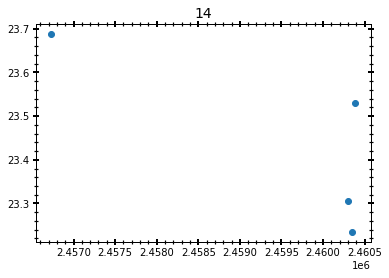

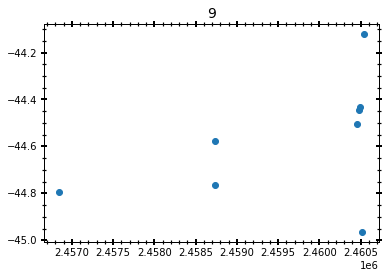

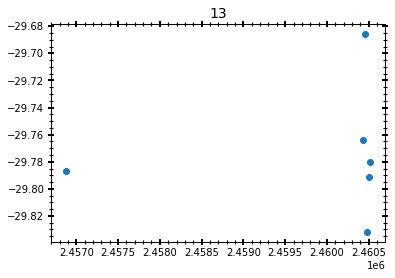

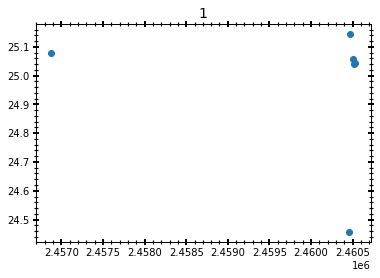

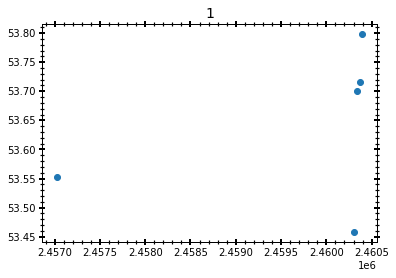

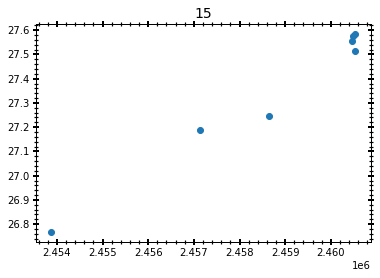

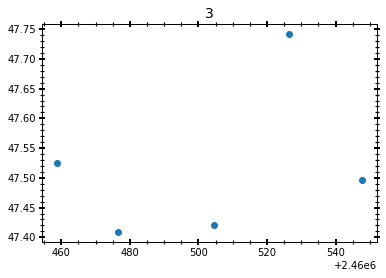

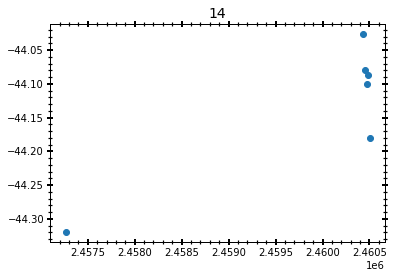

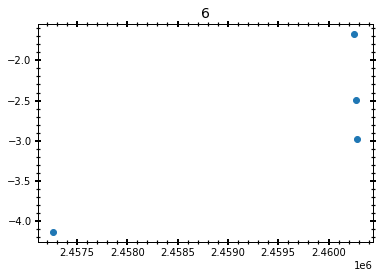

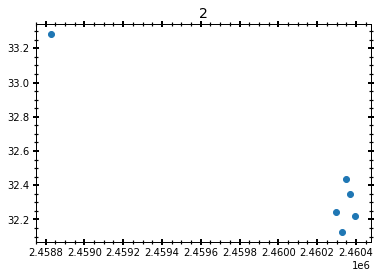

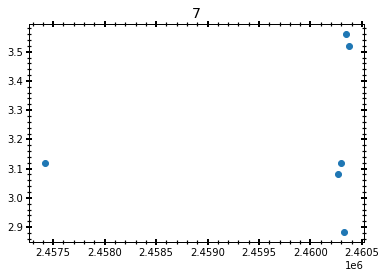

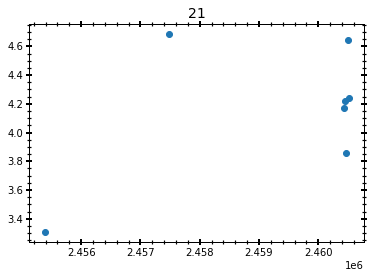

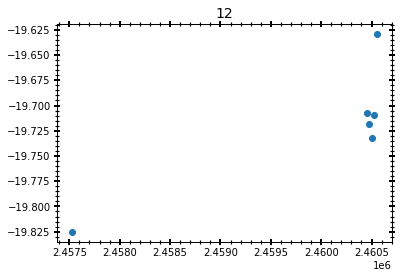

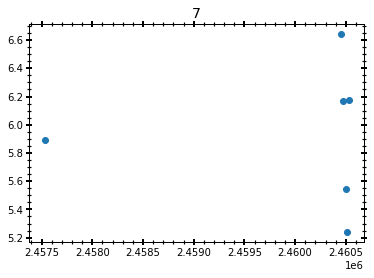

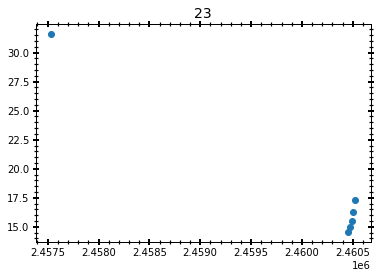

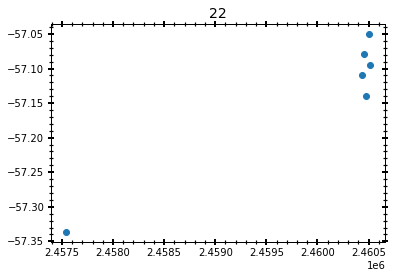

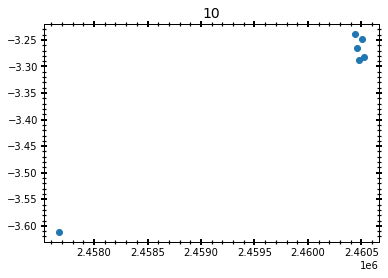

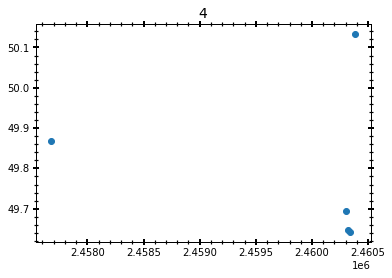

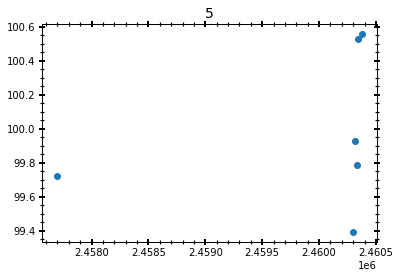

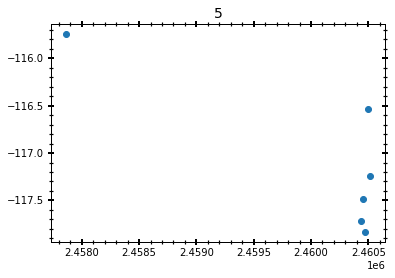

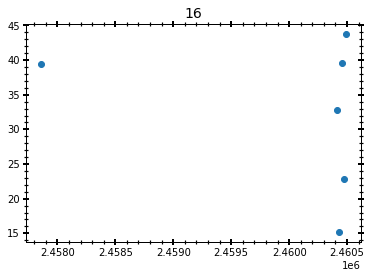

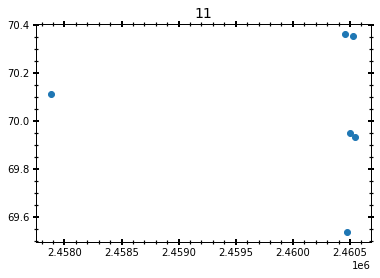

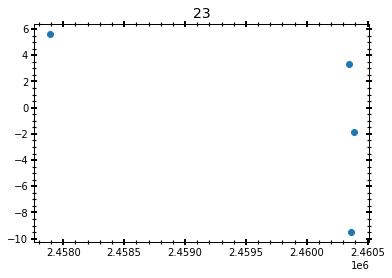

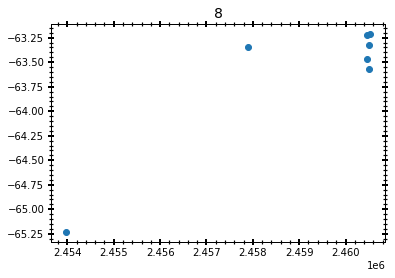

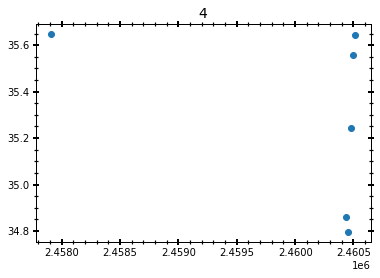

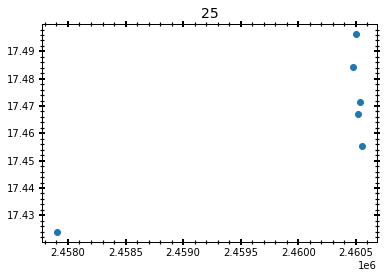

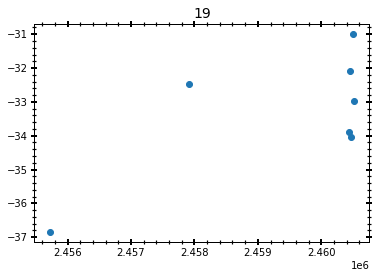

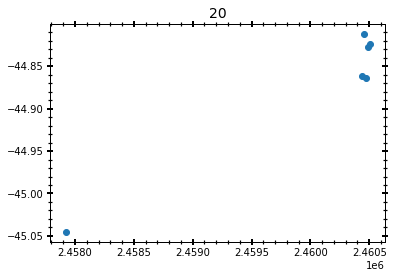

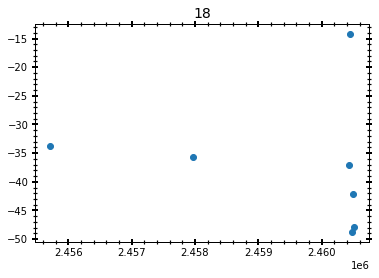

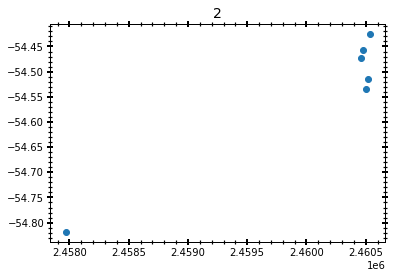

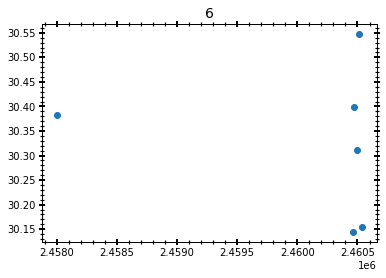

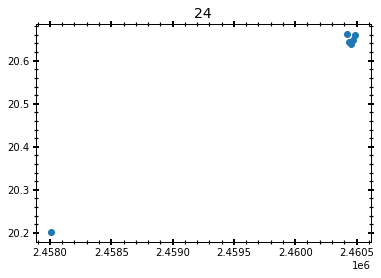

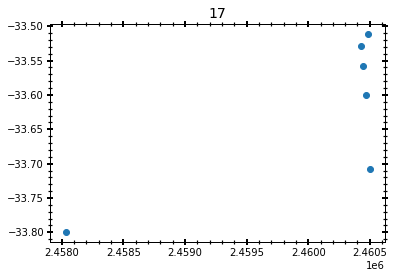

In [3]:

ids = comb_df.GALAH_ID.unique()
for i in ids:
    dt = comb_df[comb_df.GALAH_ID==i]
    plt.scatter(dt.time, dt.rv)
    
    plt.title(rv_df[rv_df.galah_id==i].RG_id.values[0])
    plt.show()


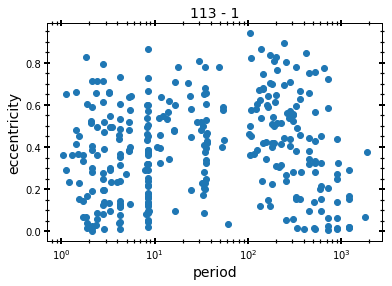

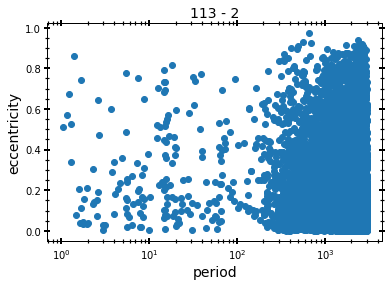

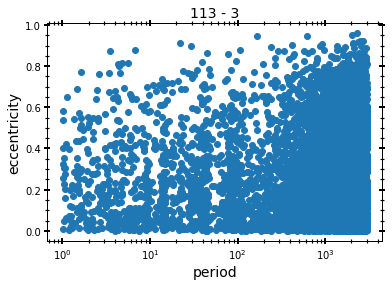

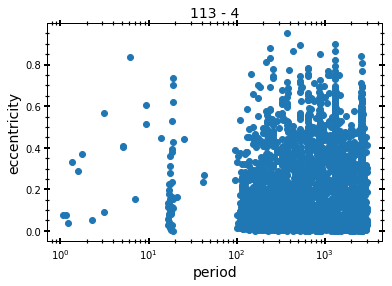

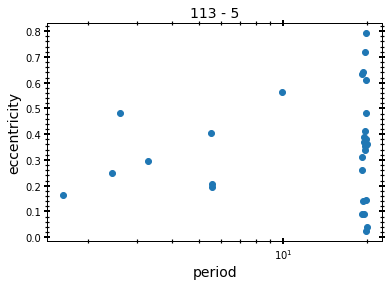

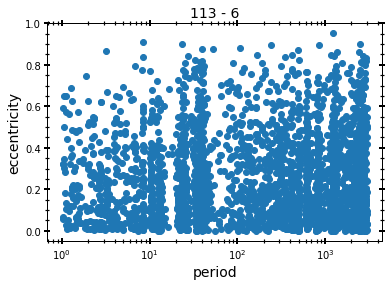

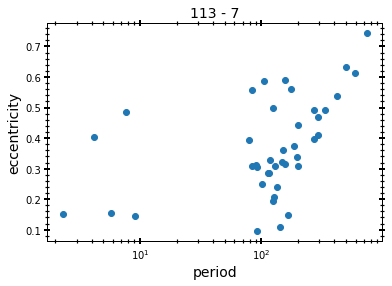

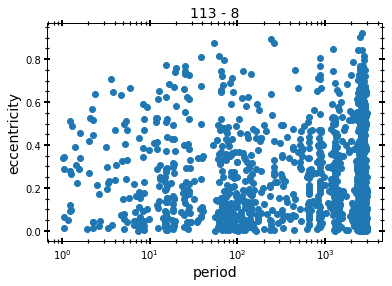

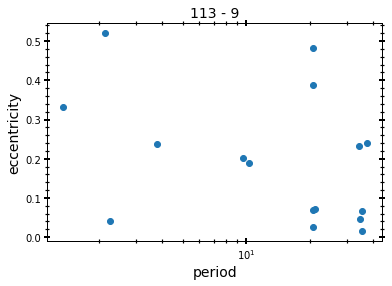

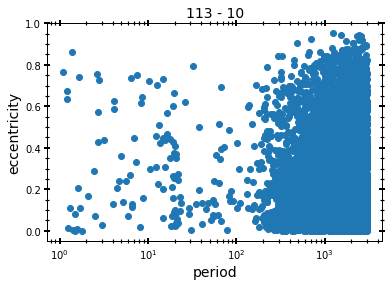

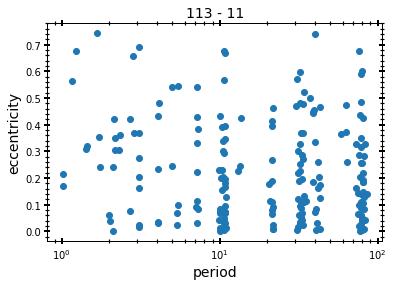

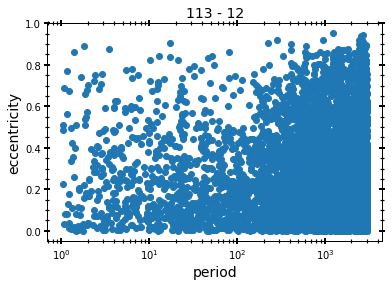

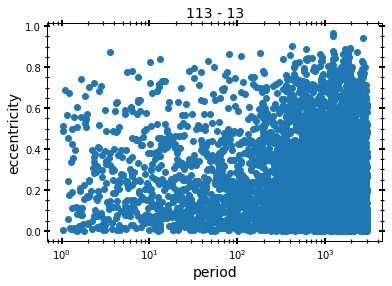

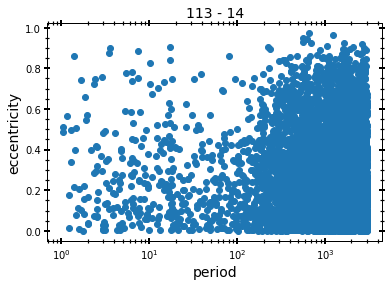

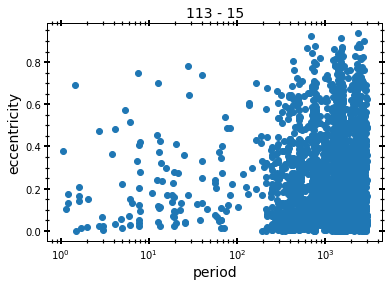

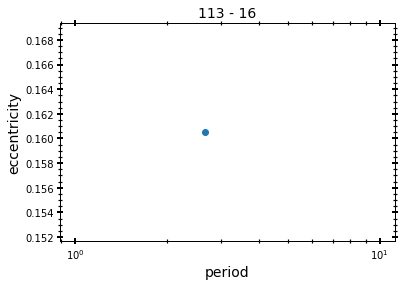

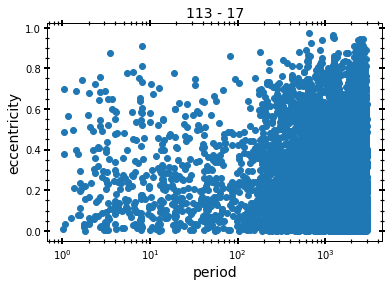

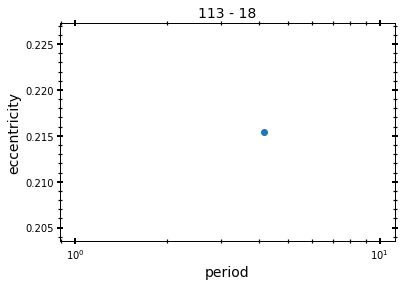

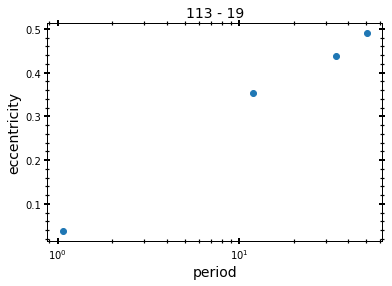

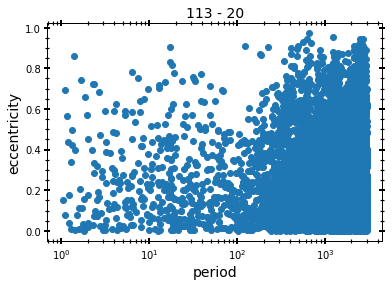

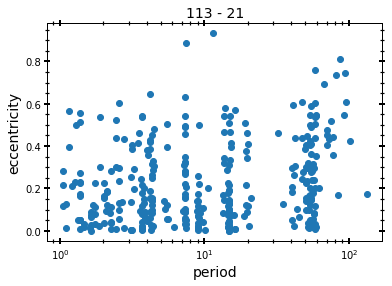

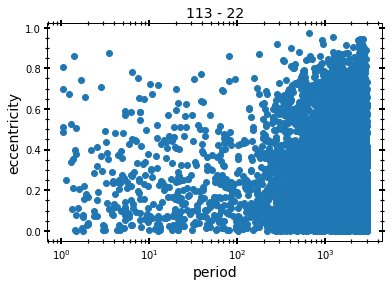

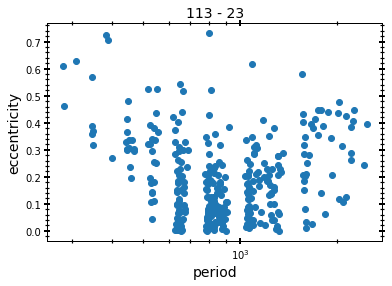

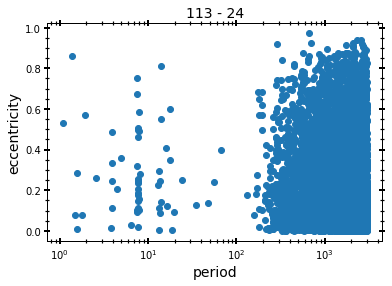

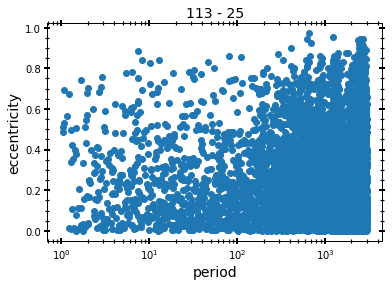

In [4]:
def plot_posteriors(obj, program):
    version = 1
    fname = '../joker_samples/%s_%s_joker_%s.hdf5'%(program,obj,version)
    joker_samples = tj.JokerSamples.read(fname)
    
#     print(joker_samples)


    plt.scatter(joker_samples['P'], joker_samples['e'])
    plt.xscale('log')
    plt.title('%s - %s' % (program,obj))
    plt.xlabel('period')
    plt.ylabel('eccentricity')


    plt.show()

for i in range(1,26,1):
    plot_posteriors(i,113)


In [5]:
def exp_vrad(logg):
    '''
    return in m/s
    '''
    siga, sigb = 0.04, 0.10
    a, b = -0.60, 3.31
    a = a+3.5*siga
    b = b+3.5*sigb
    log_v = (a*logg+b)
    return 10.**log_v

In [8]:
def K_amp(obj, program, ax):
    version = 1
    fname  = '../joker_samples/%s_%s_joker_%s.hdf5'%(program,obj,version)
    joker_samples = tj.JokerSamples.read(fname)
    dtemp  = rv_df[(rv_df.program==program) & (rv_df.RG_id==obj)]
    
    logg   = dtemp.logg.values[0]
    li_val = dtemp.Li_val.values[0]
    e_li   = dtemp.e_Li_val.values[0]
    
    K      = abs(joker_samples['K'].value)
    perc_5 = np.percentile(K, 5) #km/s
    
    # best-fit line
    threshold1 = semi_log(2000, 3.5, 10, logg) #m/s
    # 3.5 sigma line
    threshold2 = semi_log(5000, 4.0, 70, logg)
    threshold = exp_vrad(logg)
    
    threshold /= 1000 #km/s
    
    if perc_5 > 0.5: 
        ax.set_title('%s-%s 5th-per: %.2f km/s' % (program, obj, perc_5),fontsize=10)
    if perc_5 > threshold: 
        ax.set_facecolor('lightgreen')
        print(program, obj,'\t','5th-per: %.3f \t threshold: %.3f' % (perc_5, threshold))

    if len(K) != 1:
        K      = np.log10(K)
        ax.hist(K, bins='auto')
        ax.axvline(0, c='green')
        ax.axvline(np.log10(perc_5), c='r')
    
    ax.set_xlabel('log(K)')
    
    if perc_5 > threshold: 
        return True
    else:
        return False
    
# plt.figure(figsize=(9,20))
pass_threshold = {113: [], 112: []}
for i in range(1,26,1):
    ax = plt.subplot(9,3,i)
    
    x = K_amp(i,113,ax)
    if x is True: pass_threshold[113].append(i)
        
plt.tight_layout()
plt.close()

plt.figure(figsize=(12,10))
for i,obj in enumerate([1, 2, 4, 5, 6, 7, 14, 23]):
    ax = plt.subplot(4,2,i+1)
    x = K_amp(obj,112,ax)
    if x is True: pass_threshold[112].append(obj)
    
plt.tight_layout()
print(pass_threshold)
plt.close()
# # PROGRAM 112
# for i in :
#     p_val, e_val, li_val, e_li = get_samples(i,112,ax1,ax2)
#     li_vals.append(li_val)
#     p_vals.append(p_val)
#     e_vals.append(e_val)
#     e_li_vals.append(e_li)


113 9 	 5th-per: 0.250 	 threshold: 0.226
113 11 	 5th-per: 0.328 	 threshold: 0.218
113 16 	 5th-per: 15.680 	 threshold: 0.252
113 18 	 5th-per: 24.892 	 threshold: 0.313
113 19 	 5th-per: 1.812 	 threshold: 0.371
113 23 	 5th-per: 8.650 	 threshold: 0.295
112 6 	 5th-per: 1.901 	 threshold: 0.484
112 7 	 5th-per: 0.235 	 threshold: 0.231
112 23 	 5th-per: 7.725 	 threshold: 0.267
{113: [9, 11, 16, 18, 19, 23], 112: [6, 7, 23]}


[1.54 1.56 1.58 1.64 1.64 1.65 1.69 1.73 1.79 1.86 1.92 2.1  2.33 2.33
 2.37 2.55 2.55 2.6  2.67 2.68 2.68 2.95 2.96 2.98 3.16 3.24 3.32 3.41
 3.56 3.61 3.84 4.23 4.8 ]


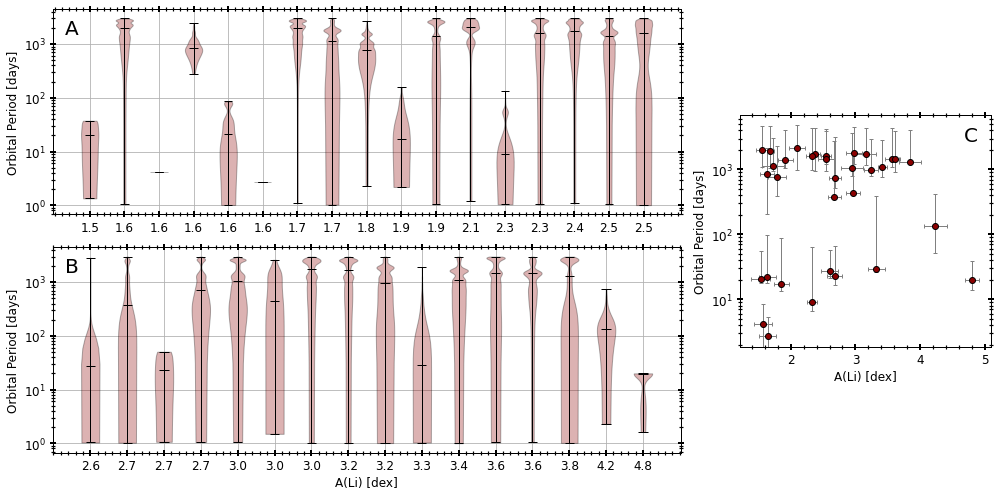

In [83]:
from utils import PLOT_PARAMS
import matplotlib.gridspec as gridspec

PLOT_PARAMS(LS=12, SIZE=12)
def get_samples(obj, program,ax1,ax2):
    version = 1
    fname  = '../joker_samples/%s_%s_joker_%s.hdf5'%(program,obj,version)
    joker_samples = tj.JokerSamples.read(fname)
    dtemp  = rv_df[(rv_df.program==program) & (rv_df.RG_id==obj)]
    li_val = dtemp.Li_val.values[0]
    e_li   = dtemp.e_Li_val.values[0]

    return joker_samples['P'].value, joker_samples['e'].value, li_val, e_li

fig = plt.figure(figsize=(14,7))    
gs = gridspec.GridSpec(2, 2, width_ratios=[2.5, 1])  # left side wider

# Axes
ax1 = fig.add_subplot(gs[0, 0])  # top left
ax2 = fig.add_subplot(gs[1, 0])  # bottom left
ax3 = fig.add_subplot(gs[:, 1])  # right (spans both rows)
ax3.set_aspect('equal', adjustable='box')

e_li_vals = []
li_vals = []
p_vals = []
e_vals = []

# PROGRAM 113
for i in range(1,26,1):
    p_val, e_val, li_val, e_li = get_samples(i,113,ax1,ax2)
    li_vals.append(li_val)
    p_vals.append(p_val)
    e_li_vals.append(e_li)

# PROGRAM 112
for i in [1, 2, 4, 5, 6, 7, 14, 23]:
    p_val, e_val, li_val, e_li = get_samples(i,112,ax1,ax2)
    li_vals.append(li_val)
    p_vals.append(p_val)
    e_li_vals.append(e_li)


li_vals   = np.array(li_vals)
idx       = np.argsort(li_vals)
li_vals   = li_vals[idx]

e_li_vals = np.array(e_li_vals)
p_vals    = [p_vals[i] for i in idx]
e_li_vals = e_li_vals[idx]
    
positions = np.arange(1, len(p_vals) + 1) # Positions 1, 2, 3, 4 for four violins
p_vals_1 = p_vals[0:17]
p_vals_2 = p_vals[17:]
pos_1 = np.arange(1, len(p_vals_1) + 1)
pos_2 = np.arange(1, len(p_vals_2) + 1)
    
# PLOTTING

vp1 = ax1.violinplot(p_vals_1,showmeans=False,showmedians=True,positions=pos_1)
vp2 = ax2.violinplot(p_vals_2,showmeans=False,showmedians=True,positions=pos_2)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_ylabel('Orbital Period [days]')
ax2.set_xlabel('A(Li) [dex]')
ax2.set_ylabel('Orbital Period [days]')

for pc in vp1['bodies']:
    pc.set_facecolor('darkred')
    pc.set_edgecolor('k')
    
for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = vp1[partname]
    vp.set_edgecolor('k')
    vp.set_linewidth(1)

for pc in vp2['bodies']:
    pc.set_facecolor('darkred')
    pc.set_edgecolor('k')
    
for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = vp2[partname]
    vp.set_edgecolor('k')
    vp.set_linewidth(1)

li_1 = ['%.1f' % i for i in li_vals[0:17]]
li_2 = ['%.1f' % i for i in li_vals[17:]]
print(li_vals)
_      = ax1.set_xticks(pos_1)
_      = ax2.set_xticks(pos_2)
_ = ax1.set_xticklabels(li_1)
_ = ax2.set_xticklabels(li_2)

ax1.grid()
ax2.grid()


e_li_vals = []
li_vals = []
p_vals = []
e_vals = []

for i in range(1,26,1):
    p_val, e_val, li_val, e_li = get_samples(i,113,ax1,ax2)
    p16, p50, p84 = np.percentile(p_val, 16), np.percentile(p_val, 50), np.percentile(p_val, 84)
    li_vals.append(li_val)
    p_vals.append([p16, p50, p84])
    e_li_vals.append(e_li)

# PROGRAM 112
for i in [1, 2, 4, 5, 6, 7, 14, 23]:
    p_val, e_val, li_val, e_li = get_samples(i,112,ax1,ax2)
    p16, p50, p84 = np.percentile(p_val, 16), np.percentile(p_val, 50), np.percentile(p_val, 84)
    li_vals.append(li_val)
    p_vals.append([p16, p50, p84])
    e_li_vals.append(e_li)
    
p_vals = np.array(p_vals)


ax3.errorbar(li_vals, p_vals[:,1], fmt='o', xerr=e_li_vals, yerr=[p_vals[:,0], p_vals[:,2]] ,lw=1,capsize=2, 
             mec='k',mfc='darkred', color='grey')
ax3.set_yscale('log')
ax3.set_xlabel('A(Li) [dex]')
ax3.set_ylabel('Orbital Period [days]')
plt.tight_layout()


ax1.text(0.02, 0.95, s='A', transform=ax1.transAxes,fontsize=20, ha='left',va='top')
ax2.text(0.02, 0.95, s='B', transform=ax2.transAxes,fontsize=20, ha='left',va='top')
ax3.text(0.95, 0.95, s='C', transform=ax3.transAxes,fontsize=20, ha='right',va='top')


plt.savefig('../plots/violin_plot_%s.png'%DATE,bbox_inches='tight',dpi=150)

In [ ]:
ss

In [13]:


def plot_rvs(obj, program, N=100):
    version = 1
    fname = '../joker_samples/%s_%s_joker_%s.hdf5'%(program,obj,version)
    joker_samples = tj.JokerSamples.read(fname)
    
    galah_id         = rv_df[(rv_df.RG_id==obj) & (rv_df.program==program)].galah_id.values[0]
    dtemp            = comb_df[comb_df.GALAH_ID==galah_id]
    time, rv, err    = dtemp.time.values, dtemp.rv.values, dtemp.rv_err.values
    sources          = np.array(dtemp.source.values)
    time, rv, err    = np.array(time), np.array(rv), np.array(err)

    data             = Table()
    data['bjd']      = time
    data['rv']       = rv
    data['err']      = err
    data["rv"].unit  = u.km / u.s
    data["err"].unit = u.km / u.s
    
    data = tj.RVData(
        t      = Time(data["bjd"], format="jd", scale="tcb"),
        rv     = u.Quantity(data["rv"]),
        rv_err = u.Quantity(data["err"]))
    
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    _ = tj.plot_rv_curves(joker_samples[:N], data=data, ax=ax)
    plt.show()



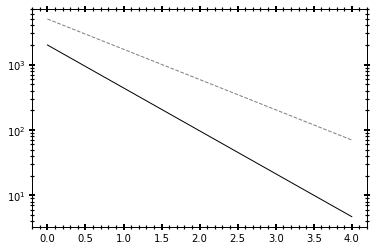

In [7]:

def semi_log(y1, x2, y2, x, x1=0):
    b = np.log10(y1)
    m = (1./x2)*np.log10(y2/y1)
    y = 10**(m*x+b)

    return y
x = np.linspace(0,4,100)    

y1=semi_log(2000, 3.5, 10, x)
# y2=semi_log(1000, 2.4, 10, x)
y3=semi_log(5000, 4.0, 70, x)

plt.plot(x,y1, c='k',ls='solid',lw=1)
# plt.plot(x,y2, c='grey',ls='dashed',label=r'$3.5\sigma$',lw=1)
plt.plot(x,y3, c='grey',ls='dashed',lw=1)
# plt.scatter(2,semi_log(2000, 3.5, 10, 2),c='r')
plt.yscale('log')

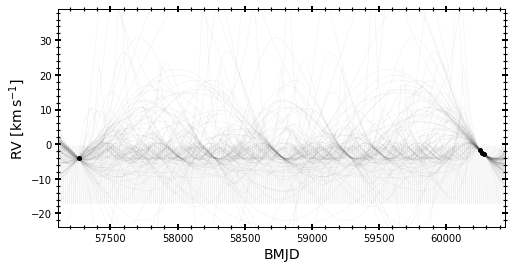

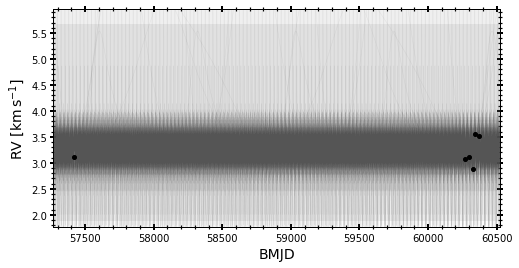

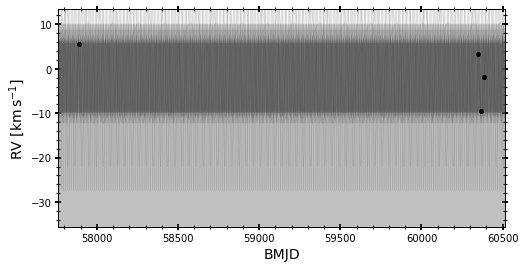

In [11]:
for obj in [6, 7, 23]:
    plot_rvs(obj, 112)


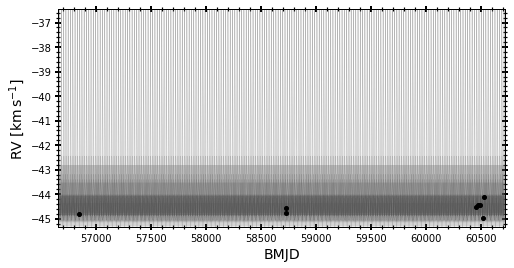

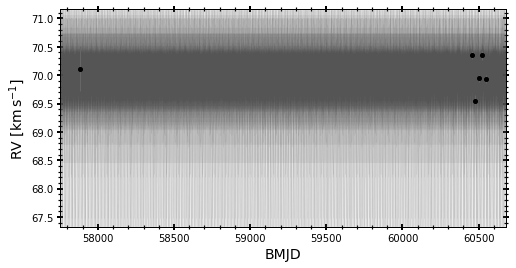

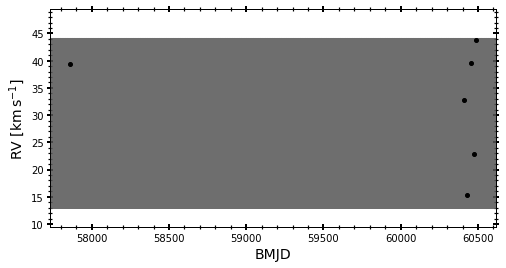

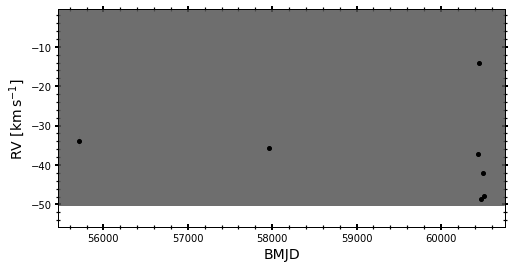

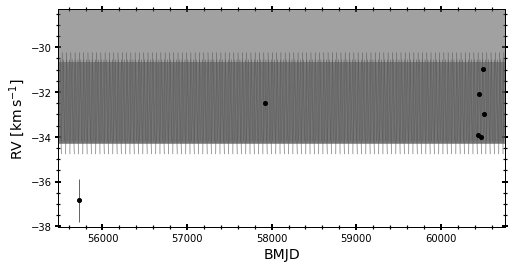

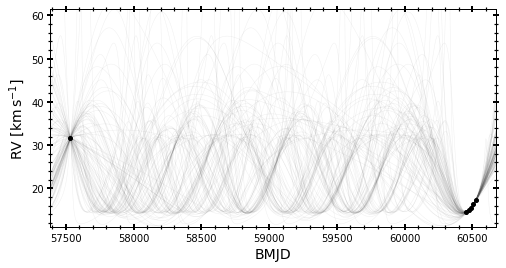

In [12]:

for obj in [9, 11, 16, 18, 19, 23,]:
    plot_rvs(obj, 113)
